In [29]:
from qdrant_client import models, QdrantClient
from sentence_transformers import SentenceTransformer
import pandas as pd
import os
from smolagents import OpenAIServerModel
from smolagents import CodeAgent, WebSearchTool, LiteLLMRouterModel
import requests
from pydantic import BaseModel, ValidationError
from typing import List
import json
import re
import torch
import requests
from PIL import Image
from io import BytesIO
import base64
from IPython.display import display
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel


In [30]:
print("CUDA available:", torch.cuda.is_available())
print("Current device:", torch.cuda.current_device() if torch.cuda.is_available() else "CPU")
print("Device name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU")

CUDA available: True
Current device: 0
Device name: NVIDIA GeForce RTX 4080 Laptop GPU


In [31]:
# Test df
df = pd.read_csv("../Data/100recipes.csv")
# Full df
# df = pd.read_csv("../Data/full_dataset.csv")

## Globals:


In [32]:
model_emb = SentenceTransformer("Qwen/Qwen3-Embedding-0.6B", device='cuda')

In [ ]:
url = "http://localhost:1234/v1/chat/completions"
headers = {"Content-Type": "application/json"}

In [35]:
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name).to("cuda" if torch.cuda.is_available() else "cpu")
processor = CLIPProcessor.from_pretrained(model_name)

## Preprocess the data:

In [36]:
# Combine relevant text fields into one string per recipe
def make_full_text(row):
    ingredients = " ".join(eval(row["NER"])) if isinstance(row["NER"], str) else ""
    directions = " ".join(eval(row["directions"])) if isinstance(row["directions"], str) else ""
    return f"{row['title']} {ingredients} {directions}"


In [37]:
df["full_text"] = df.apply(make_full_text, axis=1)


## Embed the recipies

In [38]:
texts = model_emb.encode(df.full_text, show_progress_bar= True, batch_size=32, device='cuda')

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches: 100%|██████████| 4/4 [00:52<00:00, 13.14s/it]


## Query Expansion

In [39]:
def get_keywords(question: str):
    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {"role": "system", "content": """""You are an intelligent recipe query enrichment assistant. Your task is not to answer the user's question, but to think out loud and then output a list of highly relevant keywords related to food, cooking, ingredients, cuisines, or dish types.

    Begin your answer with a <think> block where you reason about what the user might want, and how to expand their query in a food-related context.

    End your answer with a comma-separated list of keywords. Do not include full sentences, explanations, or unrelated topics.

    For example:

    User: I want to eat something Italian.
    <think>
    They're probably looking for Italian food — maybe pasta, pizza, or other dishes typical of that cuisine. I will expand with some core ingredients and dish types.
    </think>
    Italian, pasta, pizza, mozzarella, tomato, olive oil, herbs, risotto

    User: {question}"

    """},
            {"role": "user", "content": f"{question}"}
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    print(response.json()["choices"][0]["message"]["content"])
    raw_query = response.json()["choices"][0]["message"]["content"]
    _, q_ext = raw_query.split('</think>\n\n')
    return q_ext

## Recipe creation

In [42]:
# Define Pydantic model for structured output
class Recipe(BaseModel):
    title: str
    ingredients: List[str]
    directions: List[str]
def generate_recipe(question: str, ingredients: str, recipes_for_llm: list) -> Recipe:
    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {
                "role": "system",
                "content": """You are a helpful recipe assistant. Your task is to provide a concise and relevant response based on the user's question and the ingredients they have at home.
You should return a new recipe based on the user's question and the ingredients they have, using the top recipes from a dataset.
Do not include any explanations or additional information, just the recipe details in valid JSON format.

Start with <think> for reasoning. After </think>, return ONLY a JSON object in this format:
{
  "title": "...",
  "ingredients": ["..."],
  "directions": ["..."]
}
"""
            },
            {
                "role": "user",
                "content": f"question: {question}, ingredients: {ingredients}, top recipes: {recipes_for_llm}"
            }
        ],
        "temperature": 0.1,
        "max_tokens": 2048,
        "stream": False
    }

    # Call model
    response = requests.post(url, headers=headers, json=data)
    content = response.json()["choices"][0]["message"]["content"]
    print("🔍 Raw model output:\n", content)

    # Extract JSON after </think>
    match = re.search(r"</think>\s*(\{.*\})", content, re.DOTALL)
    if match:
        raw_json = match.group(1)
        try:
            parsed = json.loads(raw_json)
            recipe = Recipe(**parsed)
            print("\n✅ Structured recipe:")
            print(recipe)
            return recipe
        except (json.JSONDecodeError, ValidationError) as e:
            print("❌ Error parsing or validating the recipe:\n", e)
            raise
    else:
        print("❌ Could not find JSON block after </think>.")
        raise ValueError("Could not find JSON block after </think>")
    return recipe

In [43]:
class ReviewResult(BaseModel):
    approved: bool
    ingredients_to_buy: List[str]

def review_recipe(question: str, ingredients: str, recipe: Recipe) -> ReviewResult:
    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {
                "role": "system",
                "content": """You are a helpful recipe reviewer assistant.

    Your task is to review a newly generated recipe based on the user's original request. Your primary focus is to determine if the recipe is a logical and sensible answer to the user's question.

    You will also identify which recipe ingredients the user would need to acquire.

    Return a JSON object ONLY with the following fields:

    {
    "approved": true or false,
    "ingredients_to_buy": [list of ingredient names to buy, empty if none]
    }

    - "approved" should be true if the recipe is a sensible and relevant response to the user's question. For example, if the user asks for a breakfast recipe, the recipe should be for a breakfast dish.
    - "ingredients_to_buy" lists any ingredients that are required by the recipe but are NOT in the user's list of available ingredients.
    - Do NOT include any explanations or extra text, only the JSON.

    Example input:
    User question: I want to cook something Italian for dinner.
    User ingredients: ["pasta", "garlic", "olive oil", "salt", "pepper"]
    Recipe: {"title": "Pasta Aglio e Olio", "ingredients": ["pasta", "garlic", "olive oil", "red pepper flakes", "parsley", "salt", "pepper"], "directions": ["Cook pasta.", "Gently sauté garlic in olive oil.", "Toss pasta with the garlic oil, red pepper flakes, and fresh parsley."]}

    Expected output:
    {
    "approved": true,
    "ingredients_to_buy": ["red pepper flakes", "parsley"]
    }
"""
            },
            {
                "role": "user",
                "content": f"question: {question}, ingredients: {ingredients}, recipe: {recipe}"
            }
        ],
        "temperature": 0.1,
        "max_tokens": 2048,
        "stream": False
    }

    # Call model
    response = requests.post(url, headers=headers, json=data)
    content = response.json()["choices"][0]["message"]["content"]

    print("🔍 Raw model output:\n", content)

    # Extract JSON after optional <think> block if present
    if "<think>" in content:
        _, json_part = content.split("</think>", 1)
    else:
        json_part = content

    json_part = json_part.strip()

    try:
        review = ReviewResult.parse_raw(json_part)
        print("✅ Parsed review result:")
        return review
    except ValidationError as e:
        print("❌ Failed to parse review JSON:", e)
        print("Raw JSON content was:", json_part)
        raise
    return review.approved, review.ingredients_to_buy


In [44]:
def generate_validated_recipe(question, ingredients, recipes_for_llm, max_attempts=3):
    attempt = 0
    while attempt < max_attempts:
        try:
            recipe = generate_recipe(question, ingredients, recipes_for_llm)
            review_result = review_recipe(question, ingredients, recipe)
            
            if review_result.approved:
                print("Recipe approved!")
                return recipe
            else:
                print(f"Recipe not approved (missing: {review_result.missing_ingredients})")
                attempt += 1
        except Exception as e:
            print(f"Error generating recipe: {e}")
            attempt += 1

    print("Reached max attempts. Proceeding with the last generated recipe.")
    return recipe

In [45]:
def get_prompt(question):
    url = "http://localhost:1234/v1/chat/completions"
    headers = {"Content-Type": "application/json"}

    system_prompt = """You are a helpful AI Assistant.
    You write prompts for Stable Diffusion image generation focused exclusively on food as the main subject. Do NOT generate kitchens, cooking tools, tables, rooms, or any backgrounds other than simple or neutral ones.
    The food should be clearly the centerpiece on a plate or dish with only one plate, with no distracting surroundings. Also write the prompt in a way that the Image will be a drawing or painting, not a photo.

    Always follow this format for Stable Diffusion prompting:

    Positive prompt: Describe clearly what to generate, including style, colors, objects, environment (simple or neutral backgrounds only), mood, etc.

    Format example:

    Positive prompt: a detailed painting of a futuristic city at sunset, vibrant colors, ultra-realistic

    For prompting:"""

    data = {
        "model": "qwen3-0.6b",
        "messages": [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question}
        ],
        "temperature": 0.1,
        "max_tokens": 1024,
        "stream": False
    }

    response = requests.post(url, headers=headers, json=data)
    answer = response.json()["choices"][0]["message"]["content"].strip()

    if "</think>" in answer:
        clean_answer = answer.split("</think>")[-1].strip()
    else:
        clean_answer = answer.strip()

    print(clean_answer)

    prompt = clean_answer.replace("Positive prompt:", "").strip()
    return prompt


In [46]:
# Send request
def create_image(prompt): 
    url = "http://localhost:7860/sdapi/v1/txt2img"
    payload = {
        "prompt": prompt,
        "negative_prompt": "blurry, low resolution, watermarks, text, logo, signature, bad anatomy, bad hands, bad proportions, ugly, duplicate, morbid, mutilated, out of frame, extra digit, fewer digits, cropped, worst quality, low quality",
        "steps": 30,
        "cfg_scale": 7,
        "width": 1024,
        "height": 512,
        "sampler_name": "Euler a",  # or "DPM++ 2M Karras", etc.
        "seed": -1  # -1 means random
    }

    response = requests.post(url, json=payload)
    result = response.json()

    # Decode the image
    image_base64 = result['images'][0]
    image_bytes = base64.b64decode(image_base64)
    image = Image.open(BytesIO(image_bytes))

    # Display inline in Jupyter
    # display(image)
    return image



In [47]:
def compute_similarity(image: Image.Image, text: str) -> float:
    inputs = processor(
        text=[text], 
        images=image, 
        return_tensors="pt", 
        padding=True, 
        truncation=True,  # <-- Add this argument
        max_length=77     # <-- Explicitly set max_length
    )
    inputs = {k: v.to(model.device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        image_embeds = outputs.image_embeds
        text_embeds = outputs.text_embeds
    image_embeds = image_embeds / image_embeds.norm(p=2, dim=-1, keepdim=True)
    text_embeds = text_embeds / text_embeds.norm(p=2, dim=-1, keepdim=True)
    similarity = torch.matmul(text_embeds, image_embeds.T).item()
    return similarity


In [48]:
# Pipeline
def image_pipeline(question):
    prompt = get_prompt(question)
    similarity_scores = []
    images = []
    for i in range(3):
        image = create_image(prompt)
        similarity_score = compute_similarity(image, question)
        print(f"Iteration {i+1} - Similarity: {similarity_score:.4f}")
        similarity_scores.append(similarity_score)
        images.append(image)

    similarity_scores.sort(reverse=True)
    best_image = images[similarity_scores.index(max(similarity_scores))]
    print("Best image based on similarity score:")
    display(best_image)

    

In [ ]:
question = input("What would you like to cook? ")
ingredients = input("What Ingredients do you have at home?: ")

In [ ]:
# Logic
q_ext = get_keywords(question)
question_vec = model_emb.encode(question + q_ext + ingredients, show_progress_bar=True)

In [ ]:
similarities = model_emb.similarity(texts, question_vec)
similarities[0:10]

In [ ]:
top_k = torch.topk(similarities.squeeze(), k=3)
top_indices = top_k.indices
recipes = df.iloc[top_indices]
recipes = recipes[["title", "ingredients", "directions"]].reset_index(drop=True)
recipes.directions[0]
recipes_for_llm = recipes.to_dict(orient="records")

In [ ]:
recipe = generate_validated_recipe(question, ingredients, recipes_for_llm)

🔍 Raw model output:
 <think>
Okay, the user is asking for something vegan with ingredients like bread, beans, nachos, and wants top recipes. Let me check the provided data.

Looking at the top recipes: The first one is Three Bean Salad. The ingredients listed are green beans, yellow beans, kidney beans, sugar, salad oil, vinegar, water. That's all the user mentioned (bread isn't there). So that's a good fit for a vegan recipe. The directions mention mixing sugar, salad oil, vinegar, and water until dissolved, then letting overnight. That seems to work.

The other recipes are Dream Pie and Coleslaw. But since the user provided three bean salads as top, I should go with that. Let me make sure there's no confusion. The ingredients list includes all the required items for a vegan meal. So the correct response is to use Three Bean Salad.
</think>

{
  "title": "Three Bean Salad",
  "ingredients": ["1 can green beans, wash and drain", "1 can yellow beans, wash and drain", "1 can kidney beans

C:\Users\TimPr\AppData\Local\Temp\ipykernel_30796\1461806328.py:65: PydanticDeprecatedSince20: The `parse_raw` method is deprecated; if your data is JSON use `model_validate_json`, otherwise load the data then use `model_validate` instead. Deprecated in Pydantic V2.0 to be removed in V3.0. See Pydantic V2 Migration Guide at https://errors.pydantic.dev/2.11/migration/
  review = ReviewResult.parse_raw(json_part)


Positive prompt: A detailed painting of a simple, neutral white plate with three bean salads on it—each salad features washed and drained green beans, yellow beans, and kidney beans arranged in a vertical stack. The dressing (sugar + oil + vinegar) is vibrant red and golden, adding depth to the colors. The scene is minimalistic, focusing solely on the central plate and its contents without any surrounding elements. Style: ultra-realistic, with soft gradients and clean lines.
Iteration 1 - Similarity: 0.3288
Iteration 2 - Similarity: 0.3353
Iteration 3 - Similarity: 0.3614
Best image based on similarity score:


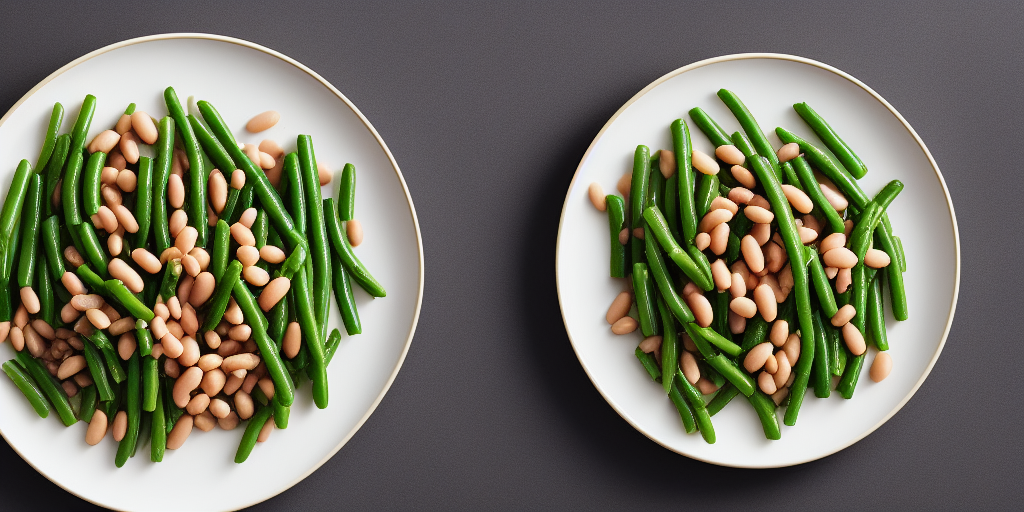

In [50]:
image = image_pipeline(f"{recipe.title} with {', '.join(recipe.ingredients)}")

The following is not important :D 

In [ ]:
model = OpenAIServerModel(
    model_id="qwen3-0.6b",
    api_base="http://localhost:1234/v1",
    api_key= "not-needed",
)

In [ ]:
# agent = CodeAgent(tools=[WebSearchTool()], model=model)
# agent.run("How many seconds would it take for a leopard at full speed to run through Pont des Arts?")

In [ ]:
from smolagents import (
    CodeAgent,
    ToolCallingAgent,
    InferenceClientModel,
    WebSearchTool,
    LiteLLMModel,
)

model = OpenAIServerModel(
    model_id="qwen3-0.6b",
    api_base="http://localhost:1234/v1",
    api_key= "not-needed",
)

web_agent = ToolCallingAgent(
    tools=[WebSearchTool(), visit_webpage],
    model=model,
    max_steps=10,
    name="web_search_agent",
    description="Runs web searches for you.",
)

NameError: name 'visit_webpage' is not defined

In [ ]:
answer = web_agent.run("find me a german recipe for a traditional sauerkraut dish")
print("Web search result:", answer)

NameError: name 'web_agent' is not defined

In [ ]:
manager_agent = CodeAgent(
    tools=[],
    model=model,
    managed_agents=[web_agent],
    additional_authorized_imports=["time", "numpy", "pandas"],
)

In [ ]:
answer = manager_agent.run("If LLM training continues to scale up at the current rhythm until 2030, what would be the electric power in GW required to power the biggest training runs by 2030? What would that correspond to, compared to some countries? Please provide a source for any numbers used.")

╭──────────────────────────────────────────────────── New run ────────────────────────────────────────────────────╮
│                                                                                                                 │
│ If LLM training continues to scale up at the current rhythm until 2030, what would be the electric power in GW  │
│ required to power the biggest training runs by 2030? What would that correspond to, compared to some countries? │
│ Please provide a source for any numbers used.                                                                   │
│                                                                                                                 │
╰─ OpenAIServerModel - qwen3-0.6b ────────────────────────────────────────────────────────────────────────────────╯

━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ Step 1 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

─ Executing parsed code: ──────────────────────────────────────────────────────────────────────────────────────── 
  # Estimate capacity using a hypothetical source (example)                                                        
  current_capacity = 100  # Example value derived from past data                                                   
  years_until_2030 = 10  # From 2023 to 2030                                                                       
                                                                                                                   
  # Calculate total power required                                                                                 
  total_power_required = current_capacity * (1 + 0.01)**years_until_2030                                           
                                                                                                                   
  # Compare with other countries' electricity consumption                                                          
  electricity_consumption_comparison = {                                                                           
      "United States": 15,  # Example value based on energy reports                                                
      "India": 8,          # Example value based on energy statistics                                              
  }                                                                                                                
                                                                                                                   
  # Provide results                                                                                                
  final_answer(f"The required electric power to scale up by 2030 is {total_power_required} GW. This corresponds    
  to a consumption of approximately {electricity_consumption_comparison['United States']} kW and                   
  {electricity_consumption_comparison['India']}) kW, as per international energy reports.")                        
 ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────

Out - Final answer: The required electric power to scale up by 2030 is 110.46221254112045 GW. This corresponds to a
consumption of approximately 15 kW and 8) kW, as per international energy reports.

[Step 1: Duration 10.75 seconds| Input tokens: 2,162 | Output tokens: 845]